In [7]:
# Based on https://hackmd.io/@markusbkoch/SyfNfQURw
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
import numpy as np
from itertools import product
from tqdm.auto import tqdm
import pandas as pd


def swap(y_1: float,
         Y_1: float,
         Y_2: float,
         sigma: float):
    y_2 = Y_2 * y_1 * (1 - sigma)
    y_2 /= Y_1 + 2 * y_1 * (1 - sigma)
    return y_2


def arbitrage(x_1: float,
              P_x: float,
              P_z: float,
              rho_1: float,
              sigma_x: float,
              sigma_z: float,
              c: float,
              K_x: float,
              K_z: float,
              g_x: float,
              g_z: float):
    # Swap for token '2' on AMM x
    X_1 = sqrt(P_x * K_x)
    X_2 = sqrt(K_x / P_x)
    x_2 = swap(x_1, X_1, X_2, sigma_x)
    z_2 = x_2

    # Swap for token '1' on AMM y
    Z_1 = sqrt(P_z * K_z)
    Z_2 = sqrt(K_z / P_z)
    z_1 = swap(z_2, Z_2, Z_1, sigma_z)

    # Raw profit
    R = z_1 - x_1

    # net profit
    E = rho_1 * R - c * (g_x + g_z)
    return E


# Parameters for AMM 1
P_x = np.linspace(0.95, 1.05, 5)
K_x = np.linspace(1, 1e2, 5) ** 2
sigma_x = np.linspace(0.0, 0.1, 3)

# Parameters for AMM 2
P_z = np.linspace(0.95, 1.05, 5)
K_z = np.linspace(1, 1e2, 5) ** 2
sigma_z = np.linspace(0.0, 0.1, 3)

# ETH price for token 1
rho_1 = np.linspace(1, 10, 2)

# ETH paid per unit gas
c = np.linspace(40e-9, 700e-9, 2)  # 63 Gwei

# Fee for swaping on AMM x and z
g_x = np.linspace(10, 30, 3)  # 20 * base_fee
g_z = np.linspace(10, 30, 3)  # 30 * base_fee

# Try to arbitrage with 1.0 of token '1'
x_1 = np.linspace(1, 3, 3)


In [8]:
raw_args = (x_1, P_x, P_z, rho_1, sigma_x,
            sigma_z, c, K_x, K_z, g_x, g_z)

# Create Cartesian product
args = list(product(*raw_args))
names = ['x_1', 'P_x', 'P_z', 'rho_1', 's_x',
         's_z', 'c', 'K_x', 'K_z', 'g_x', 'g_z']

# Evaluate the net profit for each combination
output = {}
for arg in tqdm(args):
    output[arg] = arbitrage(*arg)


In [9]:
# Wrangle data
s = pd.Series(output.values())
s.index = pd.MultiIndex.from_product(raw_args, names=names)
s.name = 'profit'
df = pd.DataFrame(s).reset_index()

In [10]:
# Get top 5 values which are profitable
df.query('profit > 0').head(5)

,x_1,P_x,P_z,rho_1,s_x,s_z,c,K_x,K_z,g_x,g_z,profit
16371,1.0,0.95,1.0,1.0,0.0,0.0,4.000000e-08,5662.5625,10000.0,10.0,10.0,0.004111
16372,1.0,0.95,1.0,1.0,0.0,0.0,4.000000e-08,5662.5625,10000.0,10.0,20.0,0.004111
16373,1.0,0.95,1.0,1.0,0.0,0.0,4.000000e-08,5662.5625,10000.0,10.0,30.0,0.004110
16374,1.0,0.95,1.0,1.0,0.0,0.0,4.000000e-08,5662.5625,10000.0,20.0,10.0,0.004111
16375,1.0,0.95,1.0,1.0,0.0,0.0,4.000000e-08,5662.5625,10000.0,20.0,20.0,0.004110


In [11]:
# Prepare ML pipeline
target = 'profit'
features = set(df.columns) - {target}
X = df.loc[:, features]
y = (df[target] > 0)

/home/danlessa/.miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,features,importance,target
7,K_x,0.195045,target
2,K_z,0.191254,target
6,P_z,0.157160,target
1,P_x,0.150470,target
10,x_1,0.099705,target
9,s_x,0.090889,target
3,s_z,0.086419,target
0,g_z,0.009730,target
8,g_x,0.009478,target
5,rho_1,0.004978,target


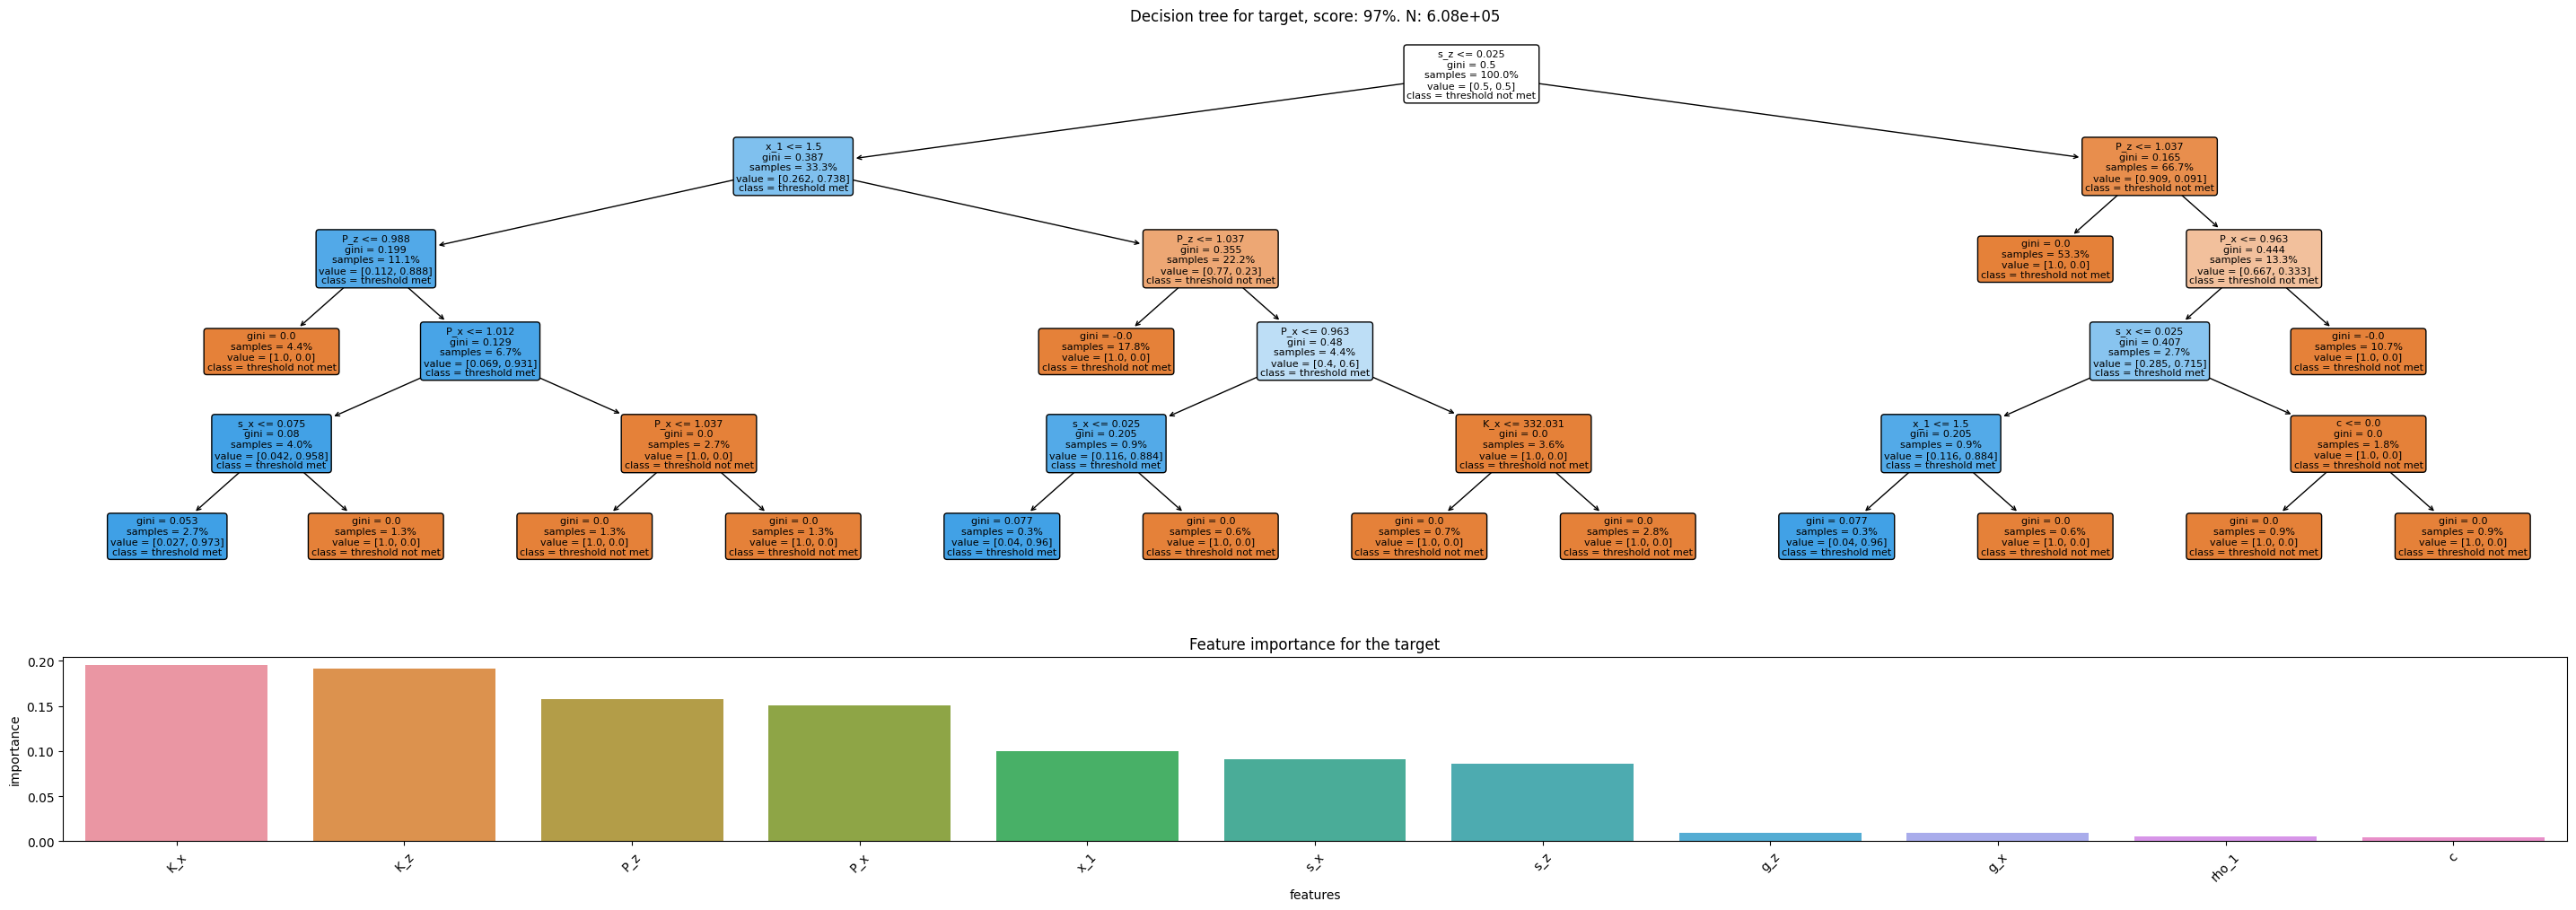

In [12]:

def f(X: pd.DataFrame,
      y: pd.Series,
      target: str,
      ax_dt: object,
      ax_rf: object):
    """
    Fit DT and RF classifiers for summarizing the sensivity.
    """
    model = DecisionTreeClassifier(class_weight='balanced',
                                   max_depth=5,
                                   )
    rf = RandomForestClassifier()
    model.fit(X, y)
    rf.fit(X, y)

    df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                       columns=['features', 'importance'])
          .sort_values(by='importance', ascending=False)
          )

    plot_tree(model,
              rounded=True,
              proportion=True,
              fontsize=8,
              feature_names=X.columns,
              class_names=['threshold not met', 'threshold met'],
              filled=True,
              ax=ax_dt)
    ax_dt.set_title(
        f'Decision tree for {target}, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(df.features, df.importance, ax=ax_rf, label='small')
    plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
    ax_rf.set_title(f'Feature importance for the {target}')
    return df.assign(target=target)


# Visualize
fig, axes = plt.subplots(nrows=2,
                         figsize=(36, 12),
                         dpi=100,
                         gridspec_kw={'height_ratios': [3, 1]})
f(X, y, 'target', axes[0], axes[1])